# Define homology gene set for human, mouse and zebrafish

In [ ]:
cds_files = {}

In [2]:
# get all the stuff from ensembl
import requests
import re
import urllib
import time


species_regex = re.compile('href=\"([a-z_]+)/\"')
file_regex = re.compile('href=\"(.+fa\.gz)\"')

release = 'release-113'
fasta = requests.get(f'https://ftp.ensembl.org/pub/{release}/fasta/')

for species in species_regex.findall(fasta.text):
    # put this here to allow easy rerunning in case it fails
    if species in cds_files:
        continue
        
    r = requests.get(f'https://ftp.ensembl.org/pub/{release}/fasta/{species}/cds/')
    match = file_regex.search(r.text)
    
    if not match:
        continue
        
    file = match.groups()[0]
    time.sleep(0.5)
    print(f'retrieving {file} for {species}')
    urllib.request.urlretrieve(
        f'https://ftp.ensembl.org/pub/{release}/fasta/{species}/cds/{file}', 
        f'../cds/{file}'
    )
    cds_files[species] = f'../cds/{file}'
    time.sleep(1)

retrieving Pelusios_castaneus.Pelusios_castaneus-1.0.cds.all.fa.gz for pelusios_castaneus
retrieving Periophthalmus_magnuspinnatus.PM.fa.cds.all.fa.gz for periophthalmus_magnuspinnatus
retrieving Peromyscus_maniculatus_bairdii.HU_Pman_2.1.cds.all.fa.gz for peromyscus_maniculatus_bairdii
retrieving Petromyzon_marinus.Pmarinus_7.0.cds.all.fa.gz for petromyzon_marinus
retrieving Phascolarctos_cinereus.phaCin_unsw_v4.1.cds.all.fa.gz for phascolarctos_cinereus
retrieving Phasianus_colchicus.ASM414374v1.cds.all.fa.gz for phasianus_colchicus
retrieving Phocoena_sinus.mPhoSin1.pri.cds.all.fa.gz for phocoena_sinus
retrieving Physeter_catodon.ASM283717v2.cds.all.fa.gz for physeter_catodon
retrieving Piliocolobus_tephrosceles.ASM277652v2.cds.all.fa.gz for piliocolobus_tephrosceles
retrieving Podarcis_muralis.PodMur_1.0.cds.all.fa.gz for podarcis_muralis
retrieving Poecilia_formosa.PoeFor_5.1.2.cds.all.fa.gz for poecilia_formosa
retrieving Poecilia_latipinna.P_latipinna-1.0.cds.all.fa.gz for poeci

In [3]:
from codontools import io

filter_dict = {
    'transcript_biotype': 'protein_coding',
    'gene_biotype': 'protein_coding'
}

cds_frames = {
    species: io.read_cds_fasta(filename, filter_dict) 
    for species, filename 
    in cds_files.items()
}
len(cds_frames)

310

In [ ]:
def keep_longest(transcripts):
    column_subset = transcripts.loc[:, ['gene_id', 'sequence']]
    column_subset['transcript_length'] = column_subset.sequence.str.len()
    longest_idx = column_subset.groupby('gene_id').apply(
        lambda x: x['transcript_length'].idxmax()
    )
    return transcripts.loc[longest_idx, :]

longest_cds = {
    key: keep_longest(frame) for key, frame in cds_frames.items()
}

del cds_frames

In [5]:
for frame in longest_cds.values():
    frame['unversioned_gene_id'] = frame.gene_id.apply(
        lambda x: x.split('.')[0]
    )

In [6]:
from gseapy import Biomart

bm = Biomart()
datasets = bm.get_datasets()
datasets

,Dataset,Description
0,vpacos_gene_ensembl,Alpaca genes (vicPac1)
1,gevgoodei_gene_ensembl,Goodes thornscrub tortoise genes (rGopEvg1_v1.p)
2,bbbison_gene_ensembl,American bison genes (Bison_UMD1.0)
3,sstibetan_gene_ensembl,Pig - Tibetan genes (Tibetan_Pig_v2)
4,lcalcarifer_gene_ensembl,Barramundi perch genes (ASB_HGAPassembly_v1)
...,...,...
209,uparryii_gene_ensembl,Arctic ground squirrel genes (ASM342692v1)
210,ptaltaica_gene_ensembl,Tiger genes (PanTig1.0)
211,lcrocea_gene_ensembl,Large yellow croaker genes (L_crocea_2.0)
212,aocellaris_gene_ensembl,Clown anemonefish genes (ASM2253959v1)


In [8]:
from collections import defaultdict

dataset_mappings = defaultdict(list)
for key in longest_cds.keys():
    tokens = key.split('_')
    for dataset in datasets.Dataset:
        if not any(token in dataset for token in tokens):
            continue
            
        if not key[0] == dataset[0]:
            continue
            
        if not tokens[-1] in dataset:
            continue
            
        dataset_mappings[dataset].append(key)
            
key_to_dataset = {
    k: v[0] 
    for k, v
    in dataset_mappings.items()
    if len(v) < 2
}
ambiguous = {
    k: v
    for k, v
    in dataset_mappings.items()
    if len(v) > 1
}
ambiguous

{'applatyrhynchos_gene_ensembl': ['anas_platyrhynchos',
  'anas_platyrhynchos_platyrhynchos'],
 'aplatyrhynchos_gene_ensembl': ['anas_platyrhynchos',
  'anas_platyrhynchos_platyrhynchos'],
 'bihybrid_gene_ensembl': ['bos_indicus_hybrid', 'bos_taurus_hybrid'],
 'hgfemale_gene_ensembl': ['heterocephalus_glaber_female',
  'heterocephalus_glaber_male']}

In [9]:
key_to_dataset.update(
    {
        'applatyrhynchos_gene_ensembl': 'anas_platyrhynchos_platyrhynchos',
        'aplatyrhynchos_gene_ensembl': 'anas_platyrhynchos',
        'bihybrid_gene_ensembl': 'bos_indicus_hybrid',
        'hgfemale_gene_ensembl': 'heterocephalus_glaber_female'
    }
)
key_to_dataset

{'apolyacanthus_gene_ensembl': 'acanthochromis_polyacanthus',
 'amelanoleuca_gene_ensembl': 'ailuropoda_melanoleuca',
 'acitrinellus_gene_ensembl': 'amphilophus_citrinellus',
 'aocellaris_gene_ensembl': 'amphiprion_ocellaris',
 'apercula_gene_ensembl': 'amphiprion_percula',
 'atestudineus_gene_ensembl': 'anabas_testudineus',
 'acarolinensis_gene_ensembl': 'anolis_carolinensis',
 'abrachyrhynchus_gene_ensembl': 'anser_brachyrhynchus',
 'anancymaae_gene_ensembl': 'aotus_nancymaae',
 'acchrysaetos_gene_ensembl': 'aquila_chrysaetos_chrysaetos',
 'acalliptera_gene_ensembl': 'astatotilapia_calliptera',
 'amexicanus_gene_ensembl': 'astyanax_mexicanus',
 'bmusculus_gene_ensembl': 'balaenoptera_musculus',
 'bsplendens_gene_ensembl': 'betta_splendens',
 'bbbison_gene_ensembl': 'bison_bison_bison',
 'bgrunniens_gene_ensembl': 'bos_grunniens',
 'bmutus_gene_ensembl': 'bos_mutus',
 'btaurus_gene_ensembl': 'bos_taurus',
 'celegans_gene_ensembl': 'caenorhabditis_elegans',
 'cjacchus_gene_ensembl': 'c

In [ ]:
import time

# it's crucial that mart and ensembl release match
# otherwise you may miss a few of the homologs due to id changes
species_to_human_ensembl = {}
for dataset, species in key_to_dataset.items():
    print(species)
    if species in species_to_human_ensembl:
        print(species, 'already fetched, skipping')
        continue
        
    if species == 'homo_sapiens':
        continue
    
    nretry = 0
    while nretry < 5:
        try:
            homologs = bm.query(
                dataset = dataset,
                attributes = [
                    'ensembl_gene_id',
                    'external_gene_name',
                    'hsapiens_homolog_ensembl_gene',
                    'hsapiens_homolog_associated_gene_name'
                ]
            )
        except Exception as e:
            print(e)
            nretry += 1
            print('retry:', nretry)
            time.sleep(5)
        
        if isinstance(homologs, type(None)):
            print('no human homologs in species:', species)
            break
            
        species_to_human_ensembl[species] = homologs
        break

In [11]:
len(species_to_human_ensembl)

197

In [12]:
import pickle

with open('homologs.pkl', 'wb') as pkl:
    pickle.dump(species_to_human_ensembl, pkl)
    
with open('longest_cds.pkl', 'wb') as pkl:
    pickle.dump(longest_cds, pkl)

In [14]:
import pandas as pd
print(pd.__version__)

2.2.3


In [ ]:
import pickle
import pandas as pd

with open('homologs.pkl', 'rb') as pkl:
    species_to_human_ensembl = pickle.load(pkl)
    
with open('longest_cds.pkl', 'rb') as pkl:
    longest_cds = pickle.load(pkl)

In [15]:
for species, homologs in species_to_human_ensembl.items():
    print(species, (~homologs['hsapiens_homolog_ensembl_gene'].isna()).sum())

acanthochromis_polyacanthus 20541
ailuropoda_melanoleuca 18608
amphilophus_citrinellus 19804
amphiprion_ocellaris 19626
amphiprion_percula 20466
anabas_testudineus 20495
anolis_carolinensis 16817
anser_brachyrhynchus 14755
aotus_nancymaae 18743
aquila_chrysaetos_chrysaetos 15731
astatotilapia_calliptera 20913
astyanax_mexicanus 21480
balaenoptera_musculus 20230
betta_splendens 19523
bison_bison_bison 19224
bos_grunniens 20782
bos_mutus 19636
bos_taurus 22632
caenorhabditis_elegans 24210
callithrix_jacchus 19020
callorhinchus_milii 15266
camelus_dromedarius 20086
canis_lupus_dingo 21913
canis_lupus_familiaris 21395
capra_hircus 21958
carassius_auratus 43970
carlito_syrichta 17918
catagonus_wagneri 20364
cavia_porcellus 20370
cebus_imitator 18845
cercocebus_atys 18848
cervus_hanglu_yarkandensis 22448
chelonoidis_abingdonii 17913
chinchilla_lanigera 17634
chlorocebus_sabaeus 22802
choloepus_hoffmanni 11914
chrysemys_picta_bellii 19134
ciona_intestinalis 18009
ciona_savignyi 14275
clupea_h

In [18]:
species_list = list(species_to_human_ensembl.keys()) + ['homo_sapiens']
for species in species_list:
    print(species)
    cds = longest_cds[species].copy()
    cds.rename(
        columns = {
            'unversioned_gene_id': 'ensembl_gene_id'
        },
        inplace = True
    )
    if species in species_to_human_ensembl:
        homologs = species_to_human_ensembl[species].set_index('ensembl_gene_id')
        homolog_idx = ~homologs['hsapiens_homolog_ensembl_gene'].isna()
        if not homolog_idx.sum():
            continue

        homologs = homologs.loc[homolog_idx, :].copy()

        cds = homologs.merge(
            cds,
            on = 'ensembl_gene_id',
            how = 'left'
        )
        
    cds.to_csv(
        f'../cds/{species}_hsapiens_homologs_cds.tsv',
        sep = '\t'
    )

acanthochromis_polyacanthus
ailuropoda_melanoleuca
amphilophus_citrinellus
amphiprion_ocellaris
amphiprion_percula
anabas_testudineus
anolis_carolinensis
anser_brachyrhynchus
aotus_nancymaae
aquila_chrysaetos_chrysaetos
astatotilapia_calliptera
astyanax_mexicanus
balaenoptera_musculus
betta_splendens
bison_bison_bison
bos_grunniens
bos_mutus
bos_taurus
caenorhabditis_elegans
callithrix_jacchus
callorhinchus_milii
camelus_dromedarius
canis_lupus_dingo
canis_lupus_familiaris
capra_hircus
carassius_auratus
carlito_syrichta
catagonus_wagneri
cavia_porcellus
cebus_imitator
cercocebus_atys
cervus_hanglu_yarkandensis
chelonoidis_abingdonii
chinchilla_lanigera
chlorocebus_sabaeus
choloepus_hoffmanni
chrysemys_picta_bellii
ciona_intestinalis
ciona_savignyi
clupea_harengus
cottoperca_gobio
coturnix_japonica
crocodylus_porosus
cyclopterus_lumpus
cynoglossus_semilaevis
cyprinodon_variegatus
cyprinus_carpio_carpio
danio_rerio
dasypus_novemcinctus
delphinapterus_leucas
denticeps_clupeoides
dicentrar

# Count codons

In [20]:
import glob
import pandas as pd

from codontools import count


codon_counts, codon_frequencies, = {}, {}
suffix = '_hsapiens_homologs_cds.tsv'
for homolog_cds_file in glob.glob(f'../cds/*{suffix}'):
    homolog_cds = pd.read_csv(
        homolog_cds_file,
        sep = '\t',
        index_col = 0
    )
    species = homolog_cds_file.split('/')[-1].removesuffix(suffix)
    print(species)
    id_col = 'hsapiens_homolog_ensembl_gene' if not species == 'homo_sapiens' else 'ensembl_gene_id'
    cds_frame = homolog_cds.loc[~homolog_cds.sequence.isna(), [id_col, 'sequence']]
    cds_frame.drop_duplicates(inplace = True)
    cds_frame.set_index(id_col, inplace = True)
    counts = count.count_codons_per_cds(cds_frame.sequence)
    frequencies = counts.divide(
        counts.sum(axis=1), 
        axis=0
    )
    codon_counts[species] = counts
    codon_frequencies[species] = frequencies
    
len(codon_counts)

lepisosteus_oculatus
ursus_americanus
procavia_capensis
phascolarctos_cinereus
choloepus_hoffmanni
cyprinus_carpio_carpio
struthio_camelus_australis
amphiprion_ocellaris
sorex_araneus
bos_mutus
loxodonta_africana
callorhinchus_milii
bos_indicus_hybrid
oryzias_melastigma
paramormyrops_kingsleyae
prolemur_simus
balaenoptera_musculus
oncorhynchus_mykiss
poecilia_latipinna
oryzias_sinensis
ochotona_princeps
macaca_fascicularis
ciona_intestinalis
sander_lucioperca
microcebus_murinus
tupaia_belangeri
macaca_mulatta
naja_naja
otolemur_garnettii
chelonoidis_abingdonii
propithecus_coquereli
urocitellus_parryii
sus_scrofa
sarcophilus_harrisii
vicugna_pacos
mesocricetus_auratus
tetraodon_nigroviridis
gopherus_evgoodei
microtus_ochrogaster
cyclopterus_lumpus
pundamilia_nyererei
sphenodon_punctatus
erpetoichthys_calabaricus
vombatus_ursinus
echinops_telfairi
electrophorus_electricus
ictidomys_tridecemlineatus
pan_troglodytes
panthera_pardus
canis_lupus_familiaris
rattus_norvegicus
astyanax_mexicanu

198

# Compute codon scores

In [21]:
codons_of_interest_G = ['AAG', 'GAG', 'CAG', 'AGG']
codons_of_interest_A = ['AAA', 'GAA', 'CAA', 'AGA']
codons_of_interest = codons_of_interest_G + codons_of_interest_A

In [22]:
score_frames = {}
for species, freq_frame in codon_frequencies.items():
    print(species, len(freq_frame))
    if freq_frame.empty:
        continue
        
    freq_frame_of_interest = freq_frame.loc[:, codons_of_interest]
    frames = []
    for endswith in 'AG':
        ending = freq_frame_of_interest.columns.str.endswith(endswith)
        total_freq = freq_frame_of_interest.loc[:, ending].sum(axis = 1)
        total_freq.name = f'{endswith}_ending'
        frames.append(total_freq)

    score_frame = pd.concat(frames, axis = 1)
    score_frame['AnG_ending'] = score_frame.sum(axis = 1)
    score_frame['ratio'] = score_frame.G_ending / score_frame.A_ending
    
    score_frames[species] = score_frame
    
len(score_frames)

lepisosteus_oculatus 14084
ursus_americanus 16655
procavia_capensis 15008
phascolarctos_cinereus 16308
choloepus_hoffmanni 11017
cyprinus_carpio_carpio 14285
struthio_camelus_australis 12456
amphiprion_ocellaris 14060
sorex_araneus 11510
bos_mutus 17220
loxodonta_africana 16804
callorhinchus_milii 13146
bos_indicus_hybrid 17290
oryzias_melastigma 13867
paramormyrops_kingsleyae 14342
prolemur_simus 17643
balaenoptera_musculus 17032
oncorhynchus_mykiss 14472
poecilia_latipinna 13835
oryzias_sinensis 13081
ochotona_princeps 14698
macaca_fascicularis 16894
ciona_intestinalis 9528
sander_lucioperca 14033
microcebus_murinus 16807
tupaia_belangeri 13606
macaca_mulatta 17527
naja_naja 14080
otolemur_garnettii 17200
chelonoidis_abingdonii 15185
propithecus_coquereli 16520
urocitellus_parryii 17150
sus_scrofa 17683
sarcophilus_harrisii 15755
vicugna_pacos 11058
mesocricetus_auratus 16220
tetraodon_nigroviridis 12901
gopherus_evgoodei 15321
microtus_ochrogaster 16771
cyclopterus_lumpus 13630
pund

198

In [88]:
!wget -O ../cds/species_tree.nw https://raw.githubusercontent.com/Ensembl/ensembl-compara/refs/heads/release/113/conf/vertebrates/species_tree.branch_len.nw

--2025-03-07 09:12:46--  https://raw.githubusercontent.com/Ensembl/ensembl-compara/refs/heads/release/113/conf/vertebrates/species_tree.branch_len.nw
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10608 (10K) [text/plain]
Saving to: ‘../cds/species_tree.nw’

../cds/species_tree 100%[===================>]  10.36K  --.-KB/s    in 0s      

2025-03-07 09:12:46 (34.6 MB/s) - ‘../cds/species_tree.nw’ saved [10608/10608]



In [23]:
from Bio import Phylo

tree = Phylo.read('../cds/species_tree.nw', 'newick')

In [24]:
species_in_tree = 0
for node in tree.get_terminals():
    if node.name in score_frames:
        species_in_tree += 1
        
species_in_tree == len(score_frames)

True

In [25]:
for node in tree.get_terminals():
    if node.name in score_frames:
        continue
        
    tree.prune(node.name)

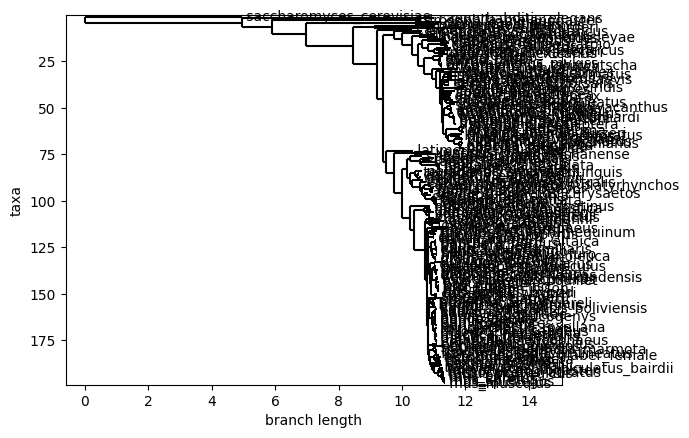

In [26]:
Phylo.draw(tree)

In [27]:
import numpy as np
import itertools as it

def terminals_distance_matrix(tree):
    terminals = list(tree.get_terminals())
    index = {
        t: i
        for i, t
        in enumerate(terminals)
    }
    distmat = np.zeros((len(terminals), len(terminals)))
    for t1, t2 in it.combinations(terminals, 2):
        i = index[t1]
        j = index[t2]
        distmat[i, j] = distmat[j, i] = tree.distance(t1, t2)

    return terminals, distmat

clades, m = terminals_distance_matrix(tree)

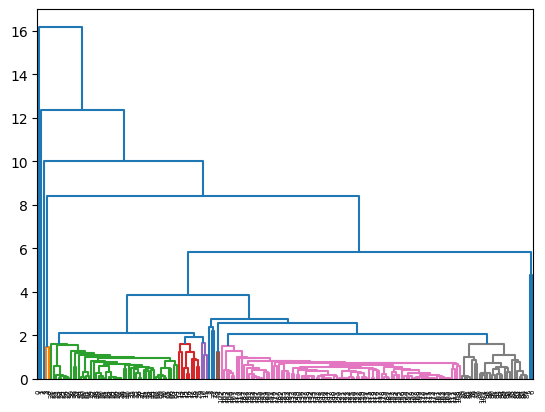

In [28]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

y = squareform(m)
linkage = linkage(y, method = 'average')
dn = dendrogram(linkage, color_threshold = 1.75)
clusters = fcluster(linkage, t = 1.75, criterion = 'distance')
cluster_assignment = {
    node.name: cluster
    for node, cluster
    in zip(clades, clusters)
}

In [29]:
import itertools as it
import numpy as np

import rbo

species_list = list(score_frames.keys())
index = {
    s: i
    for i, s
    in enumerate(species_list)
}
top_x_percent = 0.1
score_key = 'A_ending'
similarity = np.zeros(shape = (len(species_list), len(species_list)))
for (s1, i), (s2, j) in it.combinations(index.items(), 2):    
    df1 = score_frames[s1]
    df2 = score_frames[s2]
    top_x_genes_s1 = df1[score_key].nlargest(int(len(df1) * top_x_percent)).index.to_list()
    top_x_genes_s2 = df2[score_key].nlargest(int(len(df2) * top_x_percent)).index.to_list()
    similarity[i, j] = similarity[j, i] = rbo.RankingSimilarity(top_x_genes_s1, top_x_genes_s2).rbo()
    
similarity_df = pd.DataFrame(
    similarity,
    index = species_list,
    columns = species_list
)

In [41]:
similarity_df.to_csv(
    '../cds/rbo_A_ending_similarities.csv',
)

In [43]:
with open('../cds/phylogenetic_clusters.tsv', 'w') as f:
    for species, cluster in cluster_assignment.items():
        f.write(f'{species}\t{cluster}\n')

In [1]:
import pandas as pd

similarity_df = pd.read_csv(
    '../cds/rbo_A_ending_similarities.csv',
    index_col = 0
)

cluster_assignment = {}
with open('../cds/phylogenetic_clusters.tsv', 'r') as f:
    for line in f:
        species, cluster = line.rstrip().split('\t')
        cluster_assignment[species] = int(cluster)

/lisc/home/user/malzl/.conda/envs/codons/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/lisc/home/user/malzl/.conda/envs/codons/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/lisc/home/user/malzl/.conda/envs/codons/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/lisc/home/user/malzl/.conda/envs/codons/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


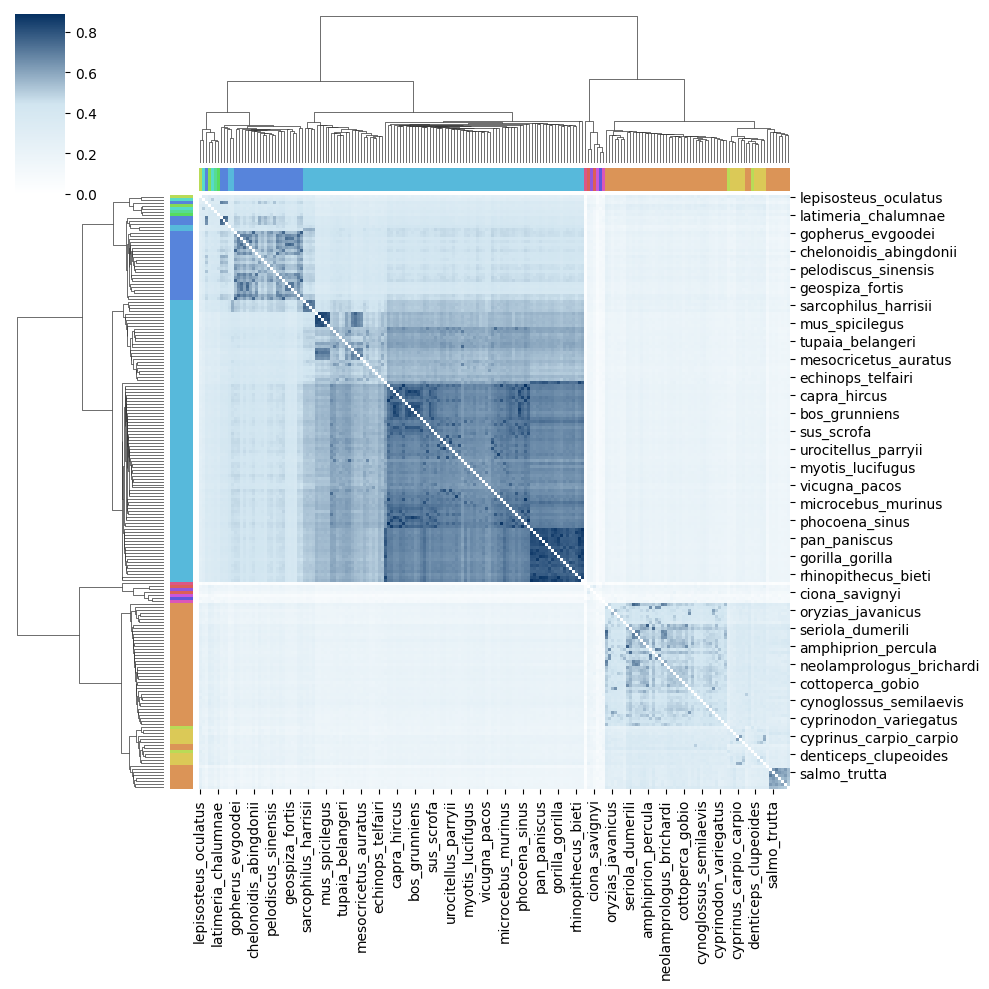

In [2]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

palette = sns.color_palette('hls', 15)

colors = [
    palette[cluster_assignment[s] - 1]
    for s
    in similarity_df.index
]

cmap = LinearSegmentedColormap.from_list(
    'somemap', 
    ['white', '#d1e5f0', '#053061'], 
    N = 256
)
clustergrid = sns.clustermap(
    similarity_df,
    col_colors = colors,
    row_colors = colors,
    cmap = cmap
)
clustergrid.savefig(
    '../plots/species_a_ending_cds_similarity.pdf'
)

[Text(5.0, 0, '1'),
 Text(15.0, 0, '2'),
 Text(25.0, 0, '3'),
 Text(35.0, 0, '4'),
 Text(45.0, 0, '5'),
 Text(55.0, 0, '6'),
 Text(65.0, 0, '7'),
 Text(75.0, 0, '8'),
 Text(85.0, 0, '9'),
 Text(95.0, 0, '10'),
 Text(105.0, 0, '11'),
 Text(115.0, 0, '12'),
 Text(125.0, 0, '13'),
 Text(135.0, 0, '14'),
 Text(145.0, 0, '15')]

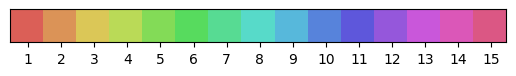

In [37]:
import numpy as np
import matplotlib.pyplot as plt

a = np.hstack([np.tile([v] * 10, (10, 1)) for v in range(1, 16)])
c = LinearSegmentedColormap.from_list(
    'somemap', 
    [palette.as_hex()[i] for i in range(15)], 
    N = 256
)
fig, ax = plt.subplots()
ax.imshow(a, cmap = c)
ax.set_yticks([])
ax.set_xticks([(2*i+1) * 10 / 2 for i in range(15)])
ax.set_xticklabels(range(1, 16))

/lisc/home/user/malzl/.conda/envs/codons/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/lisc/home/user/malzl/.conda/envs/codons/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


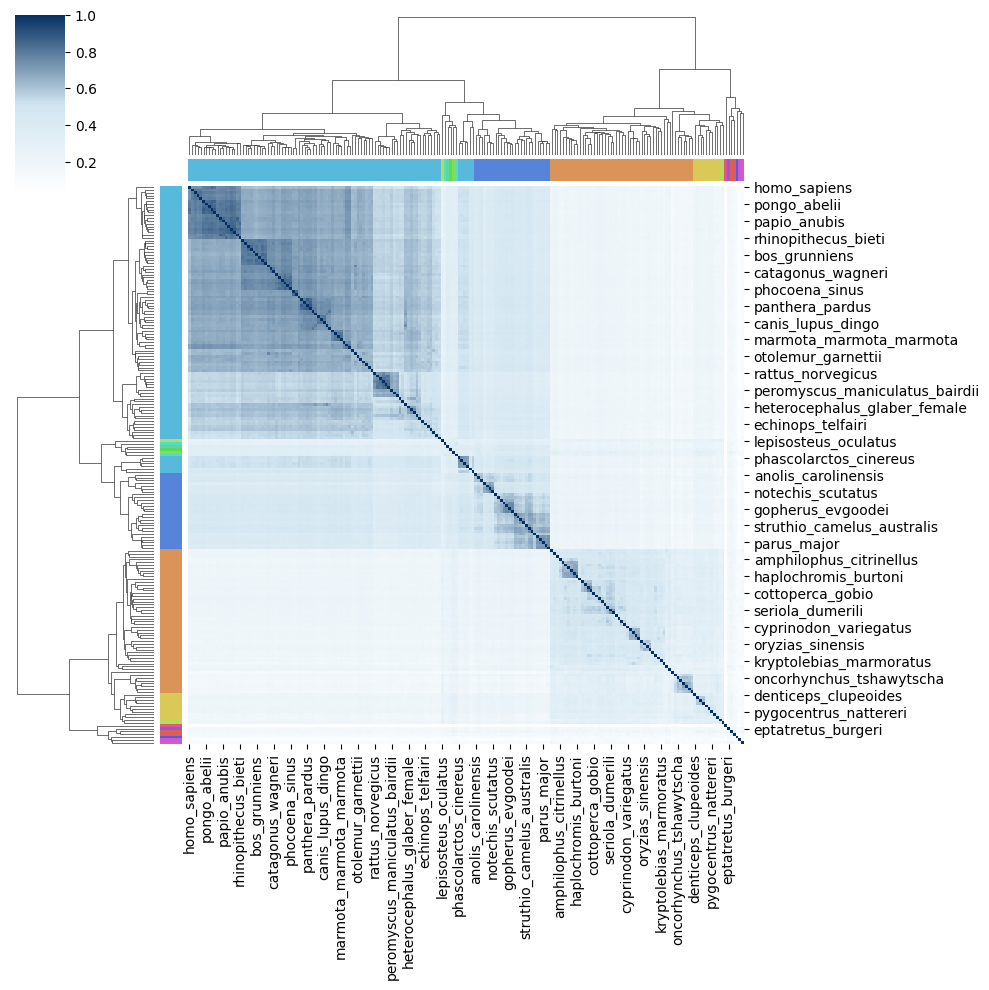

In [4]:
for species in similarity_df.index:
    similarity_df.loc[species, species] = 1

clustergrid = sns.clustermap(
    similarity_df,
    col_colors = colors,
    row_colors = colors,
    cmap = cmap
)
clustergrid.savefig(
    '../plots/species_a_ending_cds_similarity_diag1.pdf'
)

In [7]:
cluster_assignment

{'saccharomyces_cerevisiae': 15,
 'caenorhabditis_elegans': 14,
 'drosophila_melanogaster': 13,
 'ciona_savignyi': 1,
 'ciona_intestinalis': 1,
 'petromyzon_marinus': 11,
 'eptatretus_burgeri': 12,
 'callorhinchus_milii': 7,
 'erpetoichthys_calabaricus': 5,
 'lepisosteus_oculatus': 4,
 'scleropages_formosus': 4,
 'paramormyrops_kingsleyae': 4,
 'denticeps_clupeoides': 3,
 'clupea_harengus': 3,
 'danio_rerio': 3,
 'cyprinus_carpio_carpio': 3,
 'carassius_auratus': 3,
 'ictalurus_punctatus': 3,
 'electrophorus_electricus': 3,
 'pygocentrus_nattereri': 3,
 'astyanax_mexicanus': 3,
 'esox_lucius': 2,
 'hucho_hucho': 2,
 'salmo_trutta': 2,
 'salmo_salar': 2,
 'oncorhynchus_mykiss': 2,
 'oncorhynchus_tshawytscha': 2,
 'oncorhynchus_kisutch': 2,
 'gadus_morhua': 2,
 'myripristis_murdjan': 2,
 'hippocampus_comes': 2,
 'mastacembelus_armatus': 2,
 'betta_splendens': 2,
 'anabas_testudineus': 2,
 'cynoglossus_semilaevis': 2,
 'lates_calcarifer': 2,
 'seriola_lalandi_dorsalis': 2,
 'seriola_dumer

In [10]:
subset_species = [
    'homo_sapiens',
    'mus_musculus',
    'rattus_norvegicus',
    'xenopus_tropicalis',
    'danio_rerio',
    'drosophila_melanogaster',
    'saccharomyces_cerevisiae',
    'caenorhabditis_elegans',
    'gallus_gallus',
    'cavia_porcellus'
]

n_species_in_dataset = 0
for s in subset_species:
    if not s in cluster_assignment:
        print(s)
        continue
        
    n_species_in_dataset += 1
        
len(subset_species) == n_species_in_dataset

True

/lisc/user/malzl/.conda/envs/codons/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/lisc/user/malzl/.conda/envs/codons/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


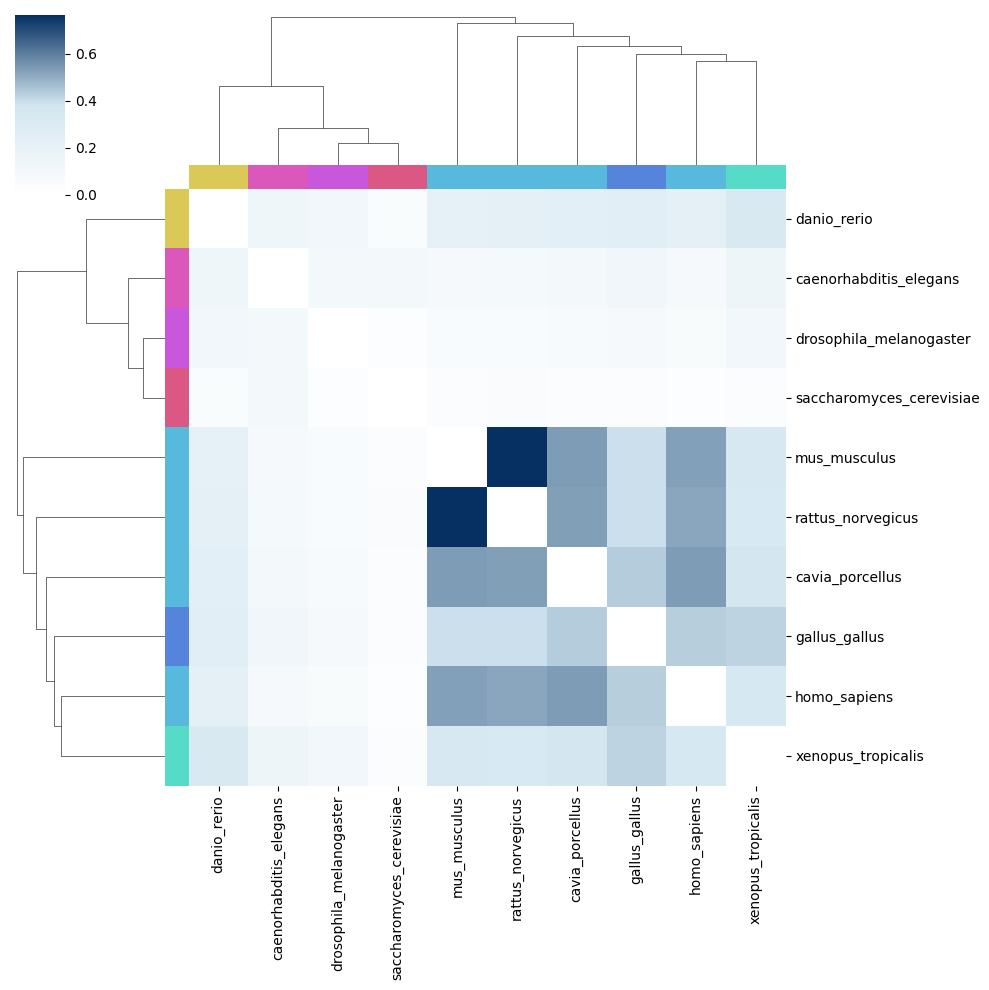

In [17]:
c = [
    palette[cluster_assignment[s] - 1]
    for s
    in subset_species
]
cg = sns.clustermap(
    similarity_df.loc[subset_species, subset_species],
    col_colors = c,
    row_colors = c,
    cmap = cmap
)   
cg.savefig(
    '../plots/species_a_ending_cds_similarity_models.pdf'
)